Jeg er ikke kommet langt med mine spekulationer, men målet er at finde et kompromis, hvor starthøjden af iskappen passer bedre med den observerede starthøjde på ca 3150 m uden at de andre dimensioner stikker helt af. Lige nu er højden i modellen fundet via. R ca. 2800 m. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Kode til generering af R-værdier

In [9]:
data1 = pd.read_excel('20temperatur.xlsx', header=29, skipfooter = 1)
data1 = data1.to_numpy()

år20_rå = data1[:,0]
temp20_rå = data1[:,1]

In [10]:
data2 = pd.read_excel('DailyMinMax_Ilullisat_Cor.xlsx', header=1)
data2 = data2.to_numpy()

år_rå = data2[:,0]
temp_rå = data2[:,1]

In [11]:
path = 'greenland_mass_200204_202311.txt'
data = np.genfromtxt(path, delimiter='', skip_header=31)
år_sat, dmasse_sat = data[:,0], data[:,1]

densitet_is = 917 #kg/m^3
dvol_sat, V_sat_err = dmasse_sat*10**12/917, 10**12 * abs(1/densitet_is * data[:,2]) # from mass to volume

In [12]:
def interpolation_år():
    interpol_år = []
    år = []
    temp = []
    for i in range(1, len(år_rå)):      # Finder mellempunkter for årsarrayet
        punkt = (år_rå[i] + år_rå[i-1])/2
        interpol_år.append(punkt)

    for i in range(len(interpol_år)):   # Laver liste med både DMI-årstal og mellempunkter
        år.append(år_rå[i])
        år.append(interpol_år[i])
    år.append(år_rå[-1])   # Tilføjer det sidste rå datapunkt manuelt, da der et ét råt datapunkt mere end mellempunkterne.
    return np.array(år)
    
år = interpolation_år()      # Interpolerer temperaturdataen

temp = np.interp(år, år_rå, temp_rå)

### Beskæring af DMI- og GRACE-data

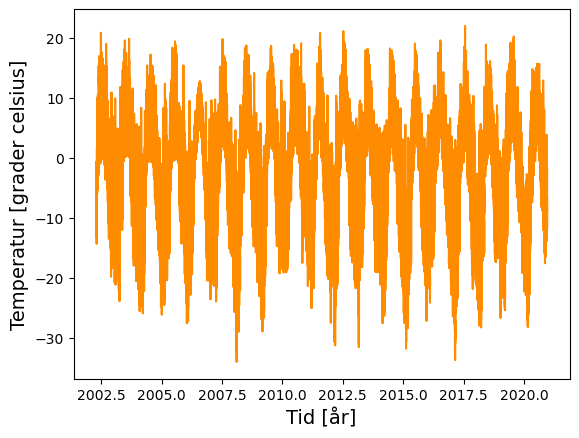

In [20]:
top = max(år_sat)
bund = min(år_sat)
år_cut = år[(år >= bund)&(år < top)]
temp = temp[(år >= bund)&(år < top)]
år = år_cut
plt.plot(år,temp, c = 'darkorange')
plt.xlabel('Tid [år]', fontsize = 14)
plt.ylabel('Temperatur [grader celsius]', fontsize = 14)

# Slicing af GRACE-data
topDMI = max(år)
dmasse_sat = dmasse_sat[år_sat <= topDMI]
dvol_sat = dvol_sat[år_sat <= topDMI]
dvol_sat_korr = dvol_sat - np.mean(dvol_sat)
V_sat_err = V_sat_err[år_sat <= topDMI]
år_sat = år_sat[år_sat <= topDMI]

In [21]:
akk_gns = 0.2034
k_acc = 2.2557
k_melt = 7.101

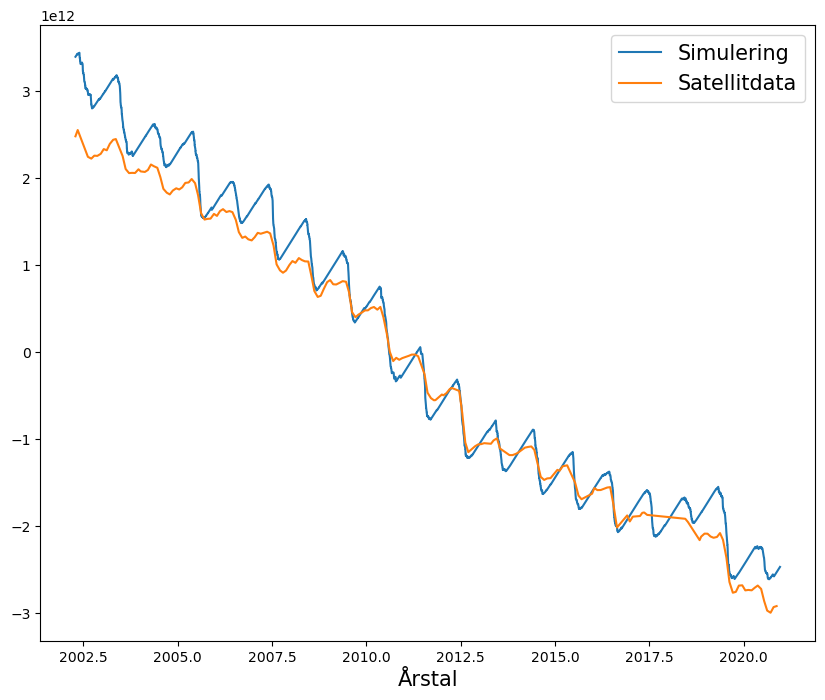

In [23]:
V_0 = 2.85 * 10**15
V = 2.85 * 10**15   # startvolumen af iskappe
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 4)  # Tidsskridt (her 1/2 døgn) - omregnet til år

# Tuningskonstanter
acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden


# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []
R_list = []

for i in range(1, len(år) + 1):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp[-i] - T_f <= 0:
        V_melt = 0 
    elif temp[-i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp[-i] - T_f) * ((T_f - temp[-i])/(alfa * k))**2 * dt # ganger tidsskridt og M på
    V +=  - V_acc + V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)
    R_list.append(R)

V_list.reverse()
dvol_sim = V_list - np.mean(V_list)
    
# Plot
    
plt.figure(figsize = (10,8))
plt.plot(år, dvol_sim, label = 'Simulering')
plt.xlabel('Årstal', fontsize = 15)## Udvælger 20 år (år 1955-1975) og bruger deres årstidscyklus på iskernedata

plt.plot(år_sat, dvol_sat_korr, label = 'Satellitdata')
plt.legend(fontsize = 15)

# Spekulationer

Når formfaktoren k bestemmes, bruges H = 3 km, men når H bestemmes via. H = k*sqrt(R) bliver H ca lig 2.8 km.

In [24]:
print(R_list[0])
H_list = np.array([])
for i in range(len(R_list)):
    H = k*np.sqrt(R_list[i])
    H_list = np.append(H_list, H)
print(H_list)

436600.22160538734
[2803.35584414 2803.35574993 2803.35565572 ... 2804.50876117 2804.50866696
 2804.50857275]


Jeg sammenligner modelværdier for arealet med en tabelværdi

In [25]:
V = 2.85 * 10**15        #m^3
H = 3 * 10**3            #m
R = 500 * 10**3          #m
A_tabel = 1710000*10**9 #m^2

print("A_tabel =", A_tabel)
print("\nR =", R)
A = 8*R**2
print("A = 8*R^2 =", A)
print("Procentvis afvigelse = ", (A-A_tabel)/A_tabel*100, "%")

R = (3/16*V/H)**(1/2)
print("\nR = (3/16*V/H)^(1/2) =", R)
A = 8*R**2
print("A = 8*R^2 =", A)
print("Procentvis afvigelse = ", (A-A_tabel)/A_tabel*100, "%")

A_tabel = 1710000000000000

R = 500000
A = 8*R^2 = 2000000000000
Procentvis afvigelse =  -99.88304093567251 %

R = (3/16*V/H)^(1/2) = 422048.5754033533
A = 8*R^2 = 1425000000000.0
Procentvis afvigelse =  -99.91666666666667 %


Store afvigelser. Der må være en enhedsfejl et sted.